In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
import numpy as np
import tensorflow as tf

from nst_utils import *
from nst_costs import *

%matplotlib inline

In [2]:
"""
1. Create an Interactive Session
2. Load the content image & style image 
3. Randomly initialize the image to be generated
4. Load the VGG16 model 
5. Build the TensorFlow graph: 
    - Run the content image through the VGG16 model and compute the content cost
    - Run the style image through the VGG16 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
6. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated
image at every step.
"""

# Reset the graph
tf.reset_default_graph()
# Start interactive session
sess = tf.InteractiveSession()

# http://www.vlfeat.org/matconvnet/pretrained/
# https://arxiv.org/abs/1508.06576
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

In [4]:
# LOAD CONTENT & STYLE IMAGES
content_path = "images/persian_cat.jpg" # tboudou_small.jpg pid_small.jpg
content_image = scipy.misc.imread(content_path)
content_image = reshape_and_normalize_image(content_image)
style_path = "images/drop-of-water.jpg" # monet.jpg
style_image = scipy.misc.imread(style_path)
style_image = reshape_and_normalize_image(style_image)

# CREATES NEW IMAGE
generated_image = generate_noise_image(content_image)
#imshow(generated_image[0])

ValueError: operands could not be broadcast together with shapes (1,300,400,3) (1,719,1280,3) 

In [4]:
# CONTENT COST
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))
# Select the output tensor of layer conv4_2
out = model['conv4_2']
# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)
# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out
# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

# STYLE COST
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))
# Compute the style cost
J_style = compute_style_cost(sess, model, STYLE_LAYERS)

# TOTAL COST
J = total_cost(J_content, J_style, 10, 40)

# DEFINE OPTIMIZER
# define optimizer
optimizer = tf.train.AdamOptimizer(1.0)
# define train_step
train_step = optimizer.minimize(J)

In [6]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        _ = sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

Iteration 0 :
total cost = 5266935000.0
content cost = 9046.28
style cost = 131671100.0
Iteration 20 :
total cost = 1173647100.0
content cost = 16368.51
style cost = 29337086.0


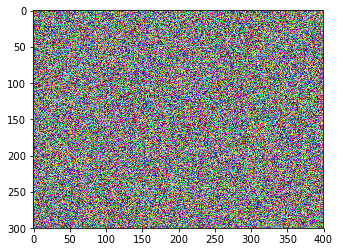

In [10]:
the_image = model_nn(sess, generated_image, 40)
imshow(the_image[0,:,:,:])